In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import my_funcs as mf

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## 1) DATA DESCRIPTION

In [4]:
# Read the excel file
V52_data_raw = pd.read_excel('V52_exel.xlsx')

# Convert the date column to datetime format
V52_data_raw.index = pd.to_datetime(V52_data_raw['Date'], format='%Y%m%d%H%M')

In [5]:
# Describe the data frame to see the statistics of the data

print(V52_data_raw.describe())

               Date       Wsp_44m      Wdir_41m        ActPow         RePow  \
count  5.224100e+04  48988.000000  48988.000000  52103.000000  52103.000000   
mean   2.018067e+11      5.595770    192.776609    139.070329     -0.071636   
std    3.474519e+06      2.796707     88.910389    203.275309      0.634039   
min    2.018010e+11      0.503833      0.001286    -27.466700     -5.744410   
25%    2.018040e+11      3.626873    125.051750     -0.400000     -0.002700   
50%    2.018070e+11      5.185345    198.823000     57.400500     -0.000527   
75%    2.018100e+11      7.081175    266.270000    175.286000      0.002410   
max    2.019010e+11     19.720000    359.997000    867.900000     11.800000   

         ActPow_std   Wsp_44m_std  Wdir_41m_std     stability  
count  52103.000000  48988.000000  48988.000000  52241.000000  
mean      36.724520      0.823869      8.386558      0.513677  
std       46.100481      0.520168      4.740973      0.499818  
min        0.000000      0.00000

In [6]:
# NOTE: different missing values from the SCADA and the met mast data
print(V52_data_raw['Wsp_44m'].isna().sum())
print(V52_data_raw['ActPow'].isna().sum())

3253
138


WIND ROSE TO VISUALIZE WIND DIRECTION AND SPEED

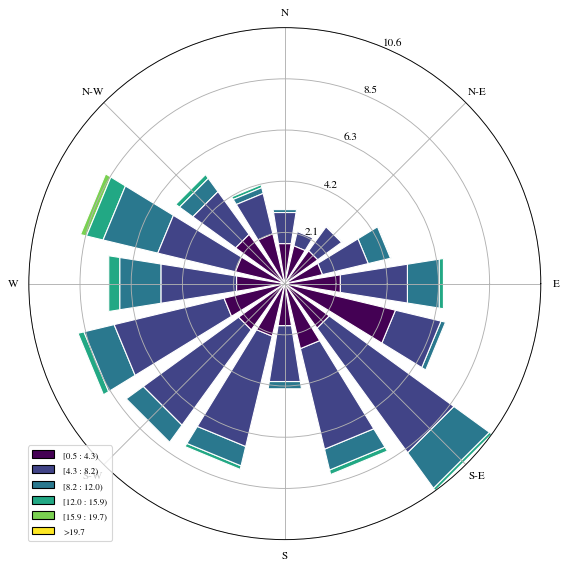

In [7]:
# Wind Rose plot -->  This will be important for the power prediction
import windrose

wd = V52_data_raw['Wdir_41m']
ws = V52_data_raw['Wsp_44m']
ax = windrose.WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.show()

## 2) CLEANING THE RAW DATA

In [8]:
# Copy for making the cleaning

V52_data = V52_data_raw.copy()

 WIND SPEED FILTERING

In [10]:
#1) PUT TO NAN VARAIBLES THAT HAVE A STD = 0 ---> very very unlikely that in 10 min the variable was stationary

columns_ws = ['Wsp_44m', 'Wsp_44m_std', 'Wdir_41m', 'Wdir_41m_std', 'stability']

# how many std = 0
print(V52_data['Wsp_44m_std'].isna().sum())
print(V52_data['Wdir_41m_std'].isna().sum())

# Wind Speed_std
V52_data.loc[V52_data['Wsp_44m_std'] == 0, columns_ws] = np.nan

# Wind direction
V52_data.loc[V52_data['Wdir_41m_std'] == 0, columns_ws] = np.nan

# 2) FILTER EXTREME VALUES
LowestWindSpeed = 0.01   # [m/s] anemometer's calm threshold
CrazyWind = 50           # [m/s] 10-minute-mean wind in Denmark has never been this high

# Wind speed filtering
V52_data.loc[V52_data['Wsp_44m'] < LowestWindSpeed, columns_ws] = np.nan
V52_data.loc[V52_data['Wsp_44m'] > CrazyWind, columns_ws] = np.nan

3253
3253


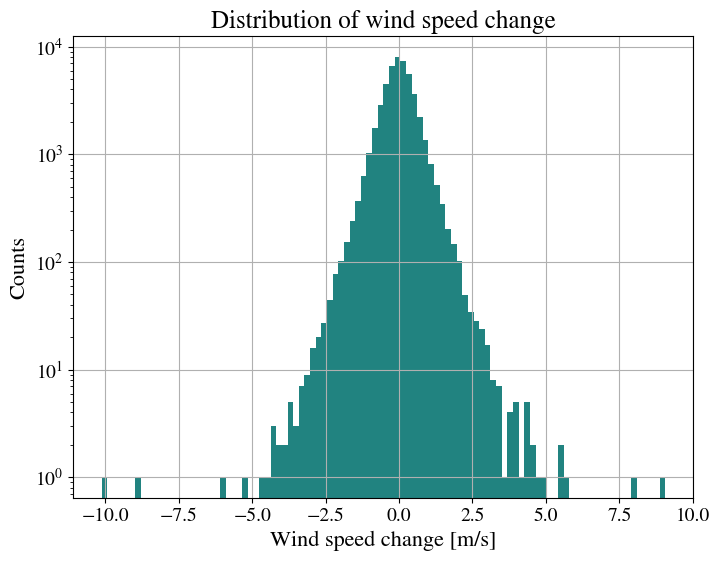

In [146]:
# 3) FILTER SUDDEN CHANGES ON WIND SPEED

# In order to choose a proper value for this... let's plot the distribution of changes in wind speed

plt.figure(figsize=(8, 6))
plt.hist(np.diff(V52_data['Wsp_44m']), bins=100, color='#218380')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.grid(True)

plt.xlabel('Wind speed change [m/s]', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.title('Distribution of wind speed change', fontsize=18)

plt.show()

In [11]:
# From the plot we can decide that a good value for the threshold is 7.5 m/s (3 standard deviations)

maxDeltaU10min = 7.5    # [m/s] the 10-minute mean wind should not jump this much from one period to the next

# Identify rows where consequtive wind speeds are bigger than the threshold
condition = abs(V52_data['Wsp_44m'].diff()) > maxDeltaU10min

# how many rows are affected?
print((V52_data['ActPow'] <= 0).sum())
# Set values to NaN for the entire row (except 'Date') where the condition is True
V52_data.loc[condition, columns_ws] = np.nan


17920


POWER FILTERING

In [106]:
# 4) DISREGARD NEGATIVE POWERS (AS WE ARE ONLY INTERESTED IN THE POWER PRODUCED BY THE TURBINE)
columns_pw = ['ActPow', 'ActPow_std', 'RePow']


V52_data.loc[V52_data['ActPow'] <= 0, columns_pw] = np.nan

In [107]:
V52_data.describe()

# IT GOT REDUCED !!!!!

,Date,Wsp_44m,Wdir_41m,ActPow,RePow,ActPow_std,Wsp_44m_std,Wdir_41m_std,stability
count,5.224100e+04,48853.000000,48853.000000,34183.000000,34183.000000,34183.000000,4.885300e+04,48853.000000,52106.000000
mean,2.018067e+11,5.589117,192.763990,212.318262,0.032529,55.706349,8.260116e-01,8.408870,0.512455
std,3.474519e+06,2.785788,88.946282,217.676639,0.354380,46.815204,5.190308e-01,4.727668,0.499850
min,2.018010e+11,0.503835,0.001286,0.009043,-4.625150,0.000000,4.129530e-07,0.000058,0.000000
25%,2.018040e+11,3.627980,124.926000,59.694600,-0.001613,21.937600,4.465050e-01,5.612100,0.000000
50%,2.018070e+11,5.181100,199.044000,124.269000,-0.000483,38.549000,7.225390e-01,7.409590,1.000000
75%,2.018100e+11,7.066760,266.389000,279.993000,0.000797,77.148450,1.094310e+00,9.739800,1.000000
max,2.019010e+11,19.720000,359.997000,867.900000,7.717470,408.458000,4.028130e+00,57.136100,1.000000


In [108]:
# Create a new column with the TI
V52_data['TI'] = V52_data['Wsp_44m_std'] / V52_data['Wsp_44m']

## 3) MISSING TIME STAMPS

In [109]:
missing_time_stamps = pd.date_range(start = V52_data.index[0], end = V52_data.index[-1], freq = '10min').difference(V52_data.index)
print('Total number of missing time stamps ', len(missing_time_stamps))
print('Missing time stamps ', missing_time_stamps)

Total number of missing time stamps  321
Missing time stamps  DatetimeIndex(['2018-01-01 13:30:00', '2018-01-01 15:50:00',
               '2018-01-02 20:20:00', '2018-01-03 00:20:00',
               '2018-01-03 18:50:00', '2018-01-04 22:00:00',
               '2018-01-06 18:20:00', '2018-01-06 19:50:00',
               '2018-01-06 20:00:00', '2018-01-07 11:40:00',
               ...
               '2018-11-21 17:20:00', '2018-11-23 17:10:00',
               '2018-11-24 18:30:00', '2018-11-25 17:00:00',
               '2018-11-25 17:10:00', '2018-11-26 20:30:00',
               '2018-12-01 17:10:00', '2018-12-03 23:10:00',
               '2018-12-05 17:00:00', '2018-12-05 19:30:00'],
              dtype='datetime64[ns]', length=321, freq=None)


In [110]:
# Fill the missing time stamps with nan
V52_data = V52_data.reindex(pd.date_range(start = V52_data.index[0], end = V52_data.index[-1], freq = '10min'))

# Fill the 'Date' column with the index values
V52_data['Date'] = V52_data.index.strftime('%Y%m%d%H%M')

missing_time_stamps2 = pd.date_range(start = V52_data.index[0], end = V52_data.index[-1], freq = '10min').difference(V52_data.index)

# See if there are missing values in the date column
print('Total number of missing time stamps ', len(missing_time_stamps2))

# Set the index to the 'Date' column
V52_data.index = pd.to_datetime(V52_data['Date'], format='%Y%m%d%H%M')

Total number of missing time stamps  0


## 4) CORRELATION BEWEEN VARIABLES

c:\Users\jorge\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


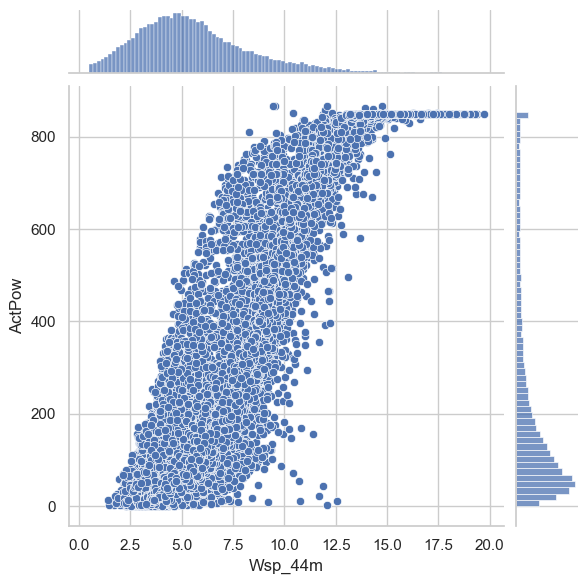

In [111]:
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Join plots of wind speed and power usind seaborn

sns.set(style="whitegrid")
sns.jointplot(x=V52_data['Wsp_44m'], y=V52_data['ActPow'], cmap='Blues',
              height=6, 
              ratio=6)


In [112]:
# Plot the wind speed and direction uwing seaborn
sns.set(style="C")
sns.jointplot(x=V52_data['Wdir_41m'], y=V52_data['ActPow'], cmap='Blues',
              height=6, 
              ratio=6)

ValueError: style must be one of white, dark, whitegrid, darkgrid, ticks

PAIRPLOT -> CORRELATION BETWEEN VARIABLES

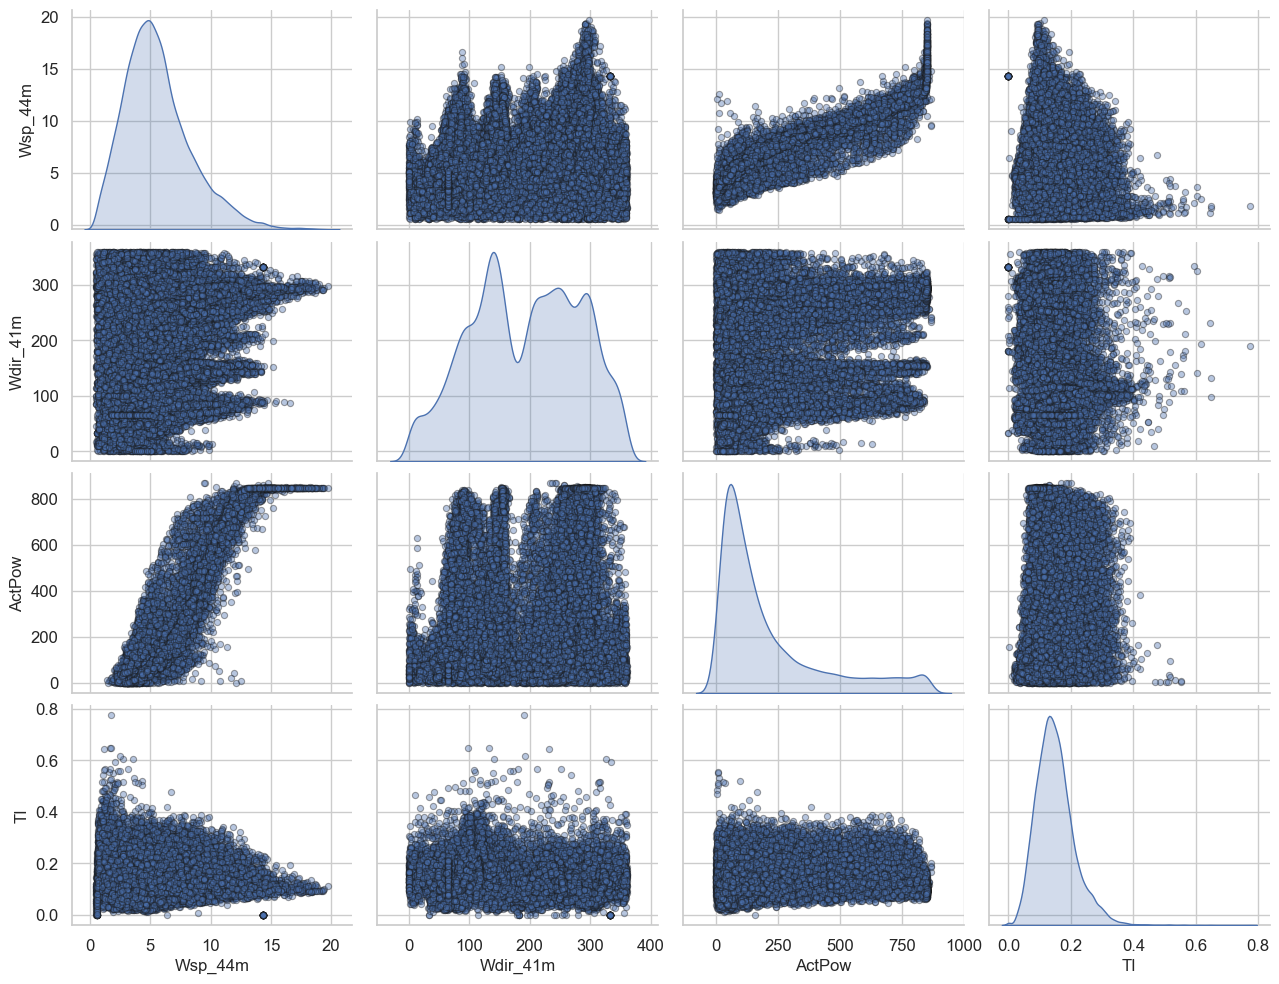

In [ ]:
#sns.set(style="darkgrid")
g= sns.pairplot(V52_data[['Wsp_44m', 'Wdir_41m', 'ActPow', 'TI']], diag_kind="kde",
             plot_kws=dict(s=20, edgecolor = 'k', linewidth=0.8, alpha=0.4),
             diag_kws=dict(shade=True),
             aspect=1.3)
g.tick_params(labelsize=12)


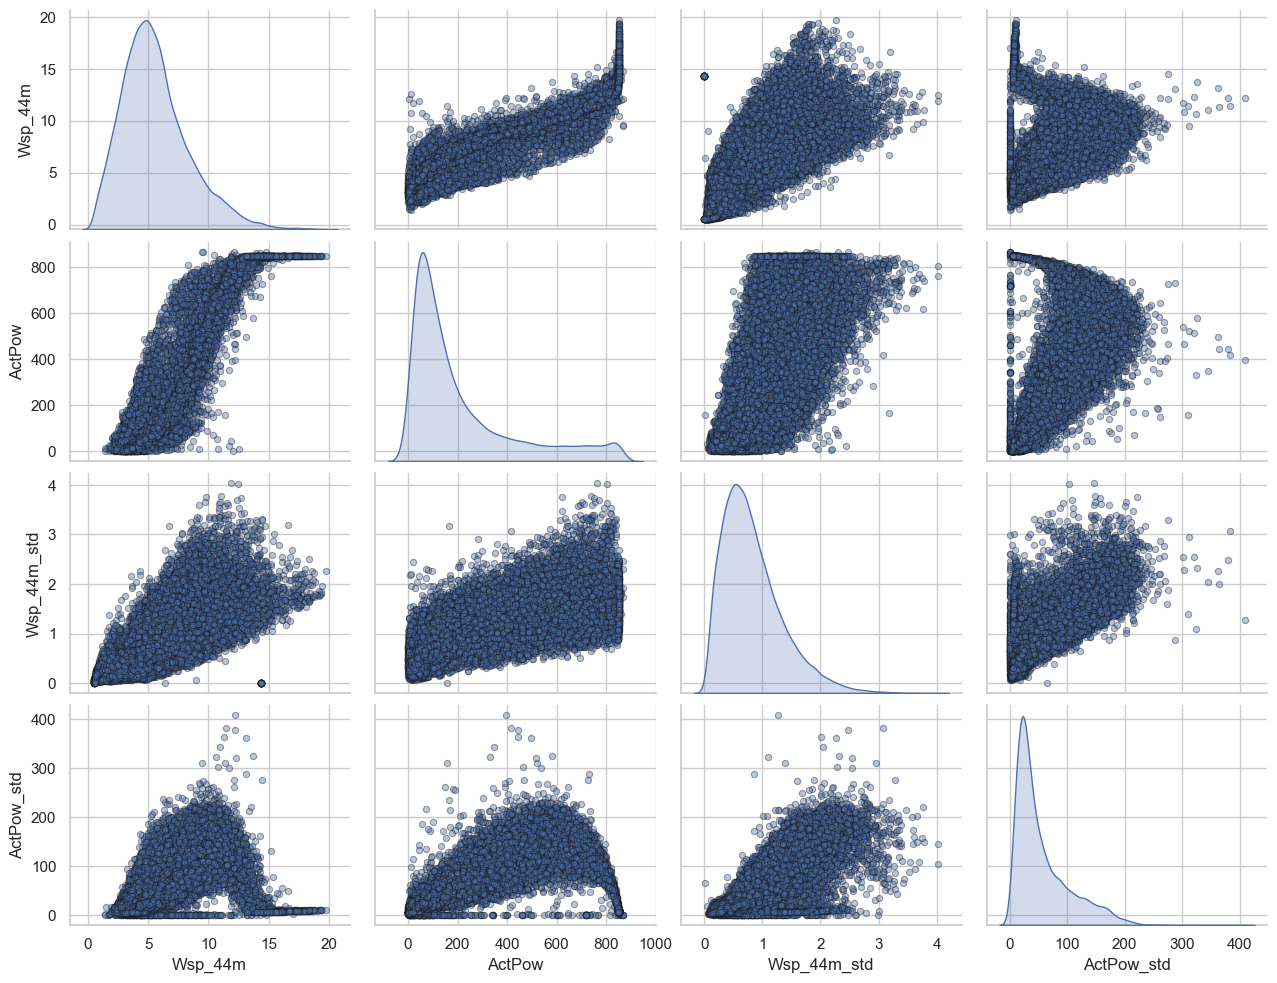

In [ ]:
sns.set(style="whitegrid")
g= sns.pairplot(V52_data[['Wsp_44m', 'ActPow', 'Wsp_44m_std', 'ActPow_std']], diag_kind="kde",
             plot_kws=dict(s=20, edgecolor = 'k', linewidth=0.8, alpha=0.4),
             diag_kws=dict(shade=True),
             aspect=1.3)

In [ ]:
### define a function that will prepare the shifting input sequences for the network
def forecast_sequences_input(input_data, n_lag):
    """
    A function that will split the input time series to sequences for nowcast/forecast problems
    Arguments:
        input_data: Time series of input observations as a list, NumPy array or pandas series
        n_lag: number of previous time steps to use for training, a.k.a. time-lag        
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = input_data.shape[1] 
    df = pd.DataFrame(input_data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


### define a function that will prepare the shifting output sequences of the network
def forecast_sequences_output(output_data,n_out):
    """
    A function that will split the output time series to sequences for nowcast/forecast problems
    Arguments:
        output_data: Time series of input observations as a list, NumPy array or pandas series
        n_out: forecast horizon (for multi-output forecast)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = output_data.shape[1] 
    df = pd.DataFrame(output_data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names    
    return agg


In [ ]:
# extract the power and date and store it in a new dataframe
ActPOW = V52_data[['Date', 'ActPow']].copy()

# set the index to the date
ActPOW.index = pd.to_datetime(ActPOW['Date'], format='%Y%m%d%H%M')

# drop the date column
ActPOW.drop(columns=['Date'], inplace=True)

# define n_lag to predict the power in the future
n_lag = 720 # 5 days
lagPow = forecast_sequences_output(ActPOW, n_lag)


In [ ]:
# see how correlates colum 1 to the rest
corr = lagPow.corr()['var1(t)'].sort_values(ascending=False)

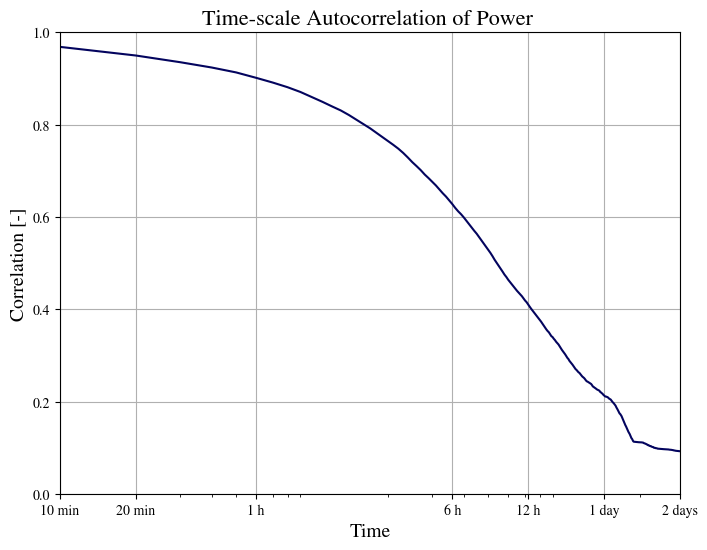

In [ ]:
# Reset grid style to default
plt.rcdefaults()
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(corr.values, '-', color='#03045e')


ax.set_title('Time-scale Autocorrelation of Power ', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Correlation [-]', fontsize=14)

ax.set_ylim([0, 1])
ax.set_xscale('log')

ax.grid(True)

ax.set_xticks([1, 2, 6, 36, 72, 144, 288])
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '10 min'
labels[1] = '20 min'
labels[2] = '1 h'
labels[3] = '6 h'
labels[4] = '12 h'
labels[5] = '1 day'
labels[6] = '2 days'




ax.set_xticklabels(labels)
ax.set_xlim([1, 288])
plt.show()

## 5) DATA FILLING

In [ ]:
# When there are 6 consecutive values of NaN, use backfill function
# make a copy of V52_data

V52_data_filled = V52_data.copy()
V52_data_filled = V52_data.fillna(method='bfill', limit=6)

In [ ]:
V52_data_filled.describe()

,Wsp_44m,Wdir_41m,ActPow,RePow,ActPow_std,Wsp_44m_std,Wdir_41m_std,stability,TI
count,49152.000000,49152.000000,37068.000000,37068.000000,37068.000000,4.915200e+04,49152.000000,52402.000000,4.915200e+04
mean,5.585802,192.733080,199.045323,-0.011834,53.973421,8.257341e-01,8.414598,0.512061,1.492603e-01
std,2.788350,88.950648,215.242947,0.443412,46.615903,5.191412e-01,4.757468,0.499859,6.188878e-02
min,0.503835,0.001286,0.009043,-4.625150,0.000000,4.129530e-07,0.000058,0.000000,6.331859e-07
25%,3.623727,124.914250,49.789100,-0.001917,21.518450,4.461823e-01,5.612607,0.000000,1.067896e-01
50%,5.179090,199.024500,112.594000,-0.000617,36.091550,7.224295e-01,7.410880,1.000000,1.423541e-01
75%,7.064485,266.311000,259.734500,0.000700,73.103350,1.094067e+00,9.744187,1.000000,1.818897e-01
max,19.720000,359.997000,867.900000,7.717470,408.458000,4.028130e+00,57.136100,1.000000,7.742675e-01


## 6) SAVE DATA

In [ ]:
## Save the proccessed data
V52_data_filled.to_csv('V52_data_process.csv', index=False)

## 7) SEE THE STATIONARY ASSUPMTION

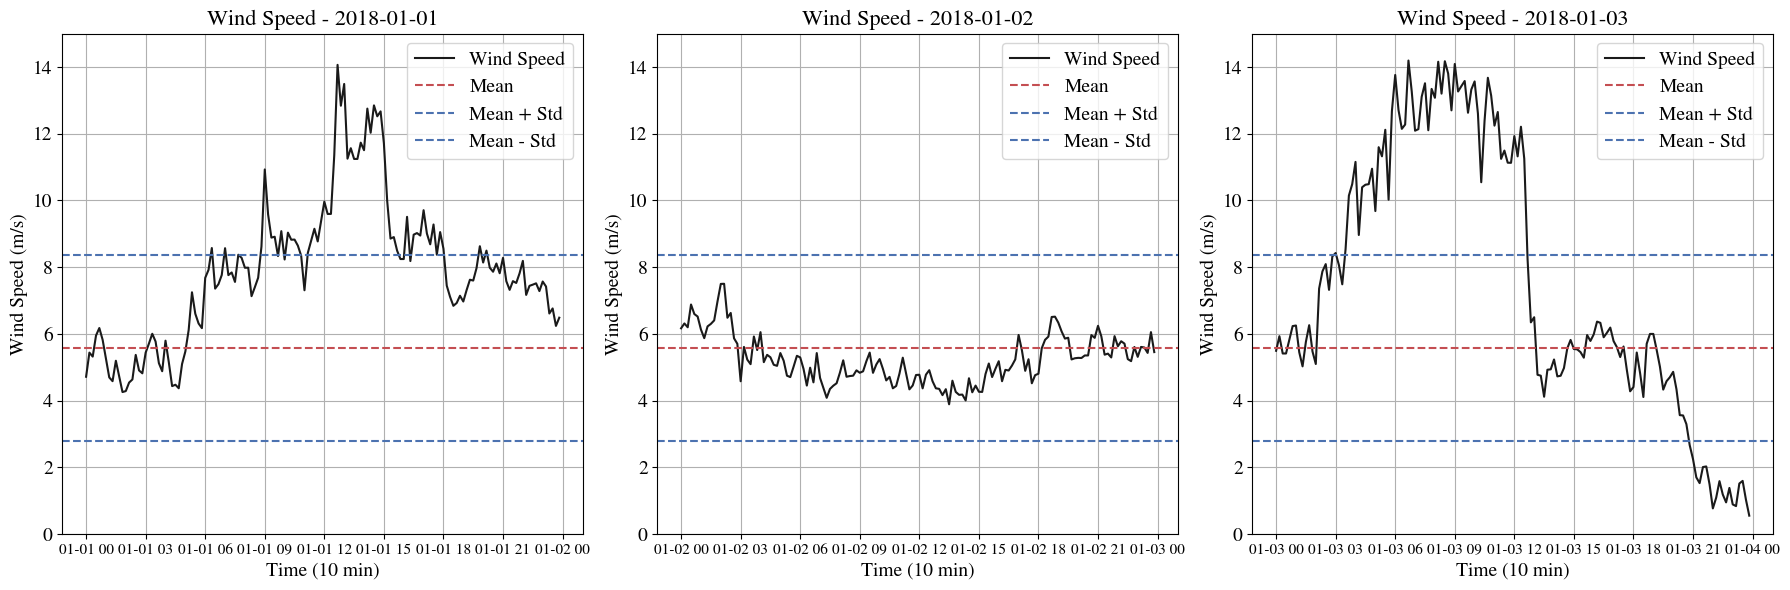

In [134]:
# Reset grid style to default
plt.rcdefaults()
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

WSP_mean = V52_data_filled['Wsp_44m'].mean()
WSP_std = V52_data_filled['Wsp_44m'].std()

# Plot three subplots next to each other at different times to see it
plt.figure(figsize=(18, 6))  # Increase width to accommodate three subplots

# Specify the dates for the three days
days = ['2018-01-01', '2018-01-02', '2018-01-03']

for i, day in enumerate(days, 1):
    plt.subplot(1, 3, i)
    subset = V52_data_filled['Wsp_44m'].loc[f'{day} 00:00:00':f'{day} 23:50:00']
    
    # Plot the data
    plt.plot(subset, 'k', label='Wind Speed')
    
    # Plot mean line
    plt.axhline(y=WSP_mean, color='r', linestyle='--', label='Mean')
    
    # Plot mean + std line
    plt.axhline(y=WSP_mean + WSP_std, color='b', linestyle='--', label='Mean + Std')
    plt.axhline(y=WSP_mean - WSP_std, color='b', linestyle='--', label='Mean - Std')
    # Customize plot
    plt.title(f'Wind Speed - {day}', fontsize=16)
    plt.xlabel('Time (10 min)', fontsize = 14)
    plt.ylabel('Wind Speed (m/s)', fontsize = 14)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=14)
    plt.ylim([0, 15])
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

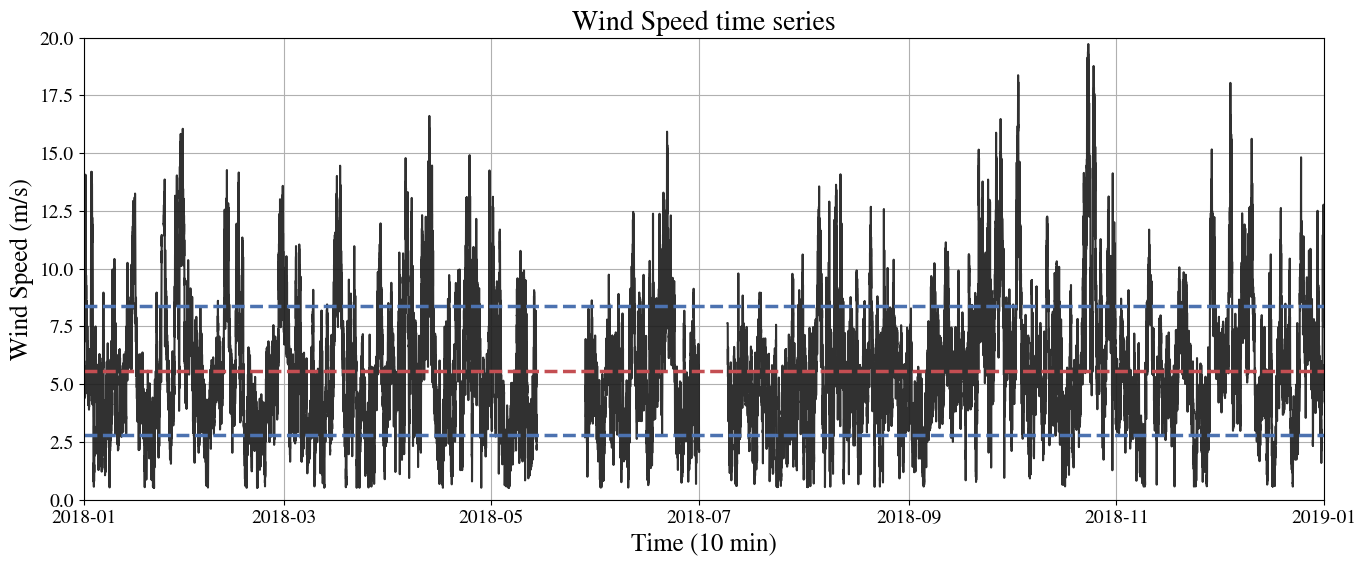

In [138]:
# plot the whole time series
plt.figure(figsize=(16, 6))
plt.plot(V52_data_filled['Wsp_44m'], 'k', label='Wind Speed', alpha=0.9)
plt.axhline(y=WSP_mean, color='r', linestyle='--', label='Mean',linewidth=2.5)
plt.axhline(y=WSP_mean + WSP_std, color='b', linestyle='--', label='Mean + Std', linewidth=2.5)                
plt.axhline(y=WSP_mean - WSP_std, color='b', linestyle='--', label='Mean - Std', linewidth=2.5)

plt.xlim([V52_data_filled.index[0], V52_data_filled.index[-1]])
plt.ylim([0, 20])

plt.title('Wind Speed time series', fontsize=20)
plt.xlabel('Time (10 min)', fontsize=18)
plt.ylabel('Wind Speed (m/s)', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)